# Practice: Semantic segmentation
_Reference: based on [Albumentations tutorial](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/)_

Today we will attempt to solve the semantic segmentation task. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The task will be to classify each pixel of an input image either as `pet` or `background`. We will use [U-Net](https://arxiv.org/abs/1505.04597) inspired architecture. We will take pretrained [EfficientNetV2](https://arxiv.org/abs/2104.00298) model as a backbone and train our task specific decoder. We will use the [PyTorch Image Models](https://github.com/rwightman/pytorch-image-models) library (aka [timm](https://pypi.org/project/timm/)) to load pretrained model and [Albumentations](https://albumentations.ai/) library for image augmentations. We will also use [Weights & Biases](https://wandb.ai/site) to log our metrics and losses during training.

## Setup

### Install libraries

In [ ]:
!pip install -U albumentations timm wandb

### Login to wandb

In [ ]:
!wandb login

### Import libraries

In [3]:
import os

import wandb
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import timm
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm, trange

device = torch.device("cuda:0")

### Download dataset

In [4]:
# We will store all data in './data' directory.
!mkdir -p data

# Images
!wget -nc https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P data
!tar xzf data/images.tar.gz -C data

# Masks
!wget -nc https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -P data
!tar xzf data/annotations.tar.gz -C data

File ‘data/images.tar.gz’ already there; not retrieving.

File ‘data/annotations.tar.gz’ already there; not retrieving.



### Split files from the dataset into the train and validation sets

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 6000 images for training, 1374 images for validation, and 10 images for testing.

In [5]:
root_directory = "data"
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [
    filename
    for filename in images_filenames 
    if cv2.imread(os.path.join(images_directory, filename)) is not None
]

random_state = 42
random_generator = np.random.default_rng(random_state)
random_generator.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:6000]
val_images_filenames = correct_images_filenames[6000:-10]
test_images_filenames = images_filenames[-10:]

print(
    len(train_images_filenames), len(val_images_filenames), len(test_images_filenames),
)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


6000 1374 10


### Preprocess masks

The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: `1`, `2`, or `3`. `1` means that this pixel of an image belongs to the class `pet`, `2` - to the class `background`, `3` - to the class `border`. Since this example demonstrates a task of binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: `0.0` if a pixel is a background and `1.0` if a pixel is a pet or a border.

In [6]:
def preprocess_mask(mask):
    background = (mask == 2)
    return np.where(background, 0.0, 1.0)

### Visualize training data

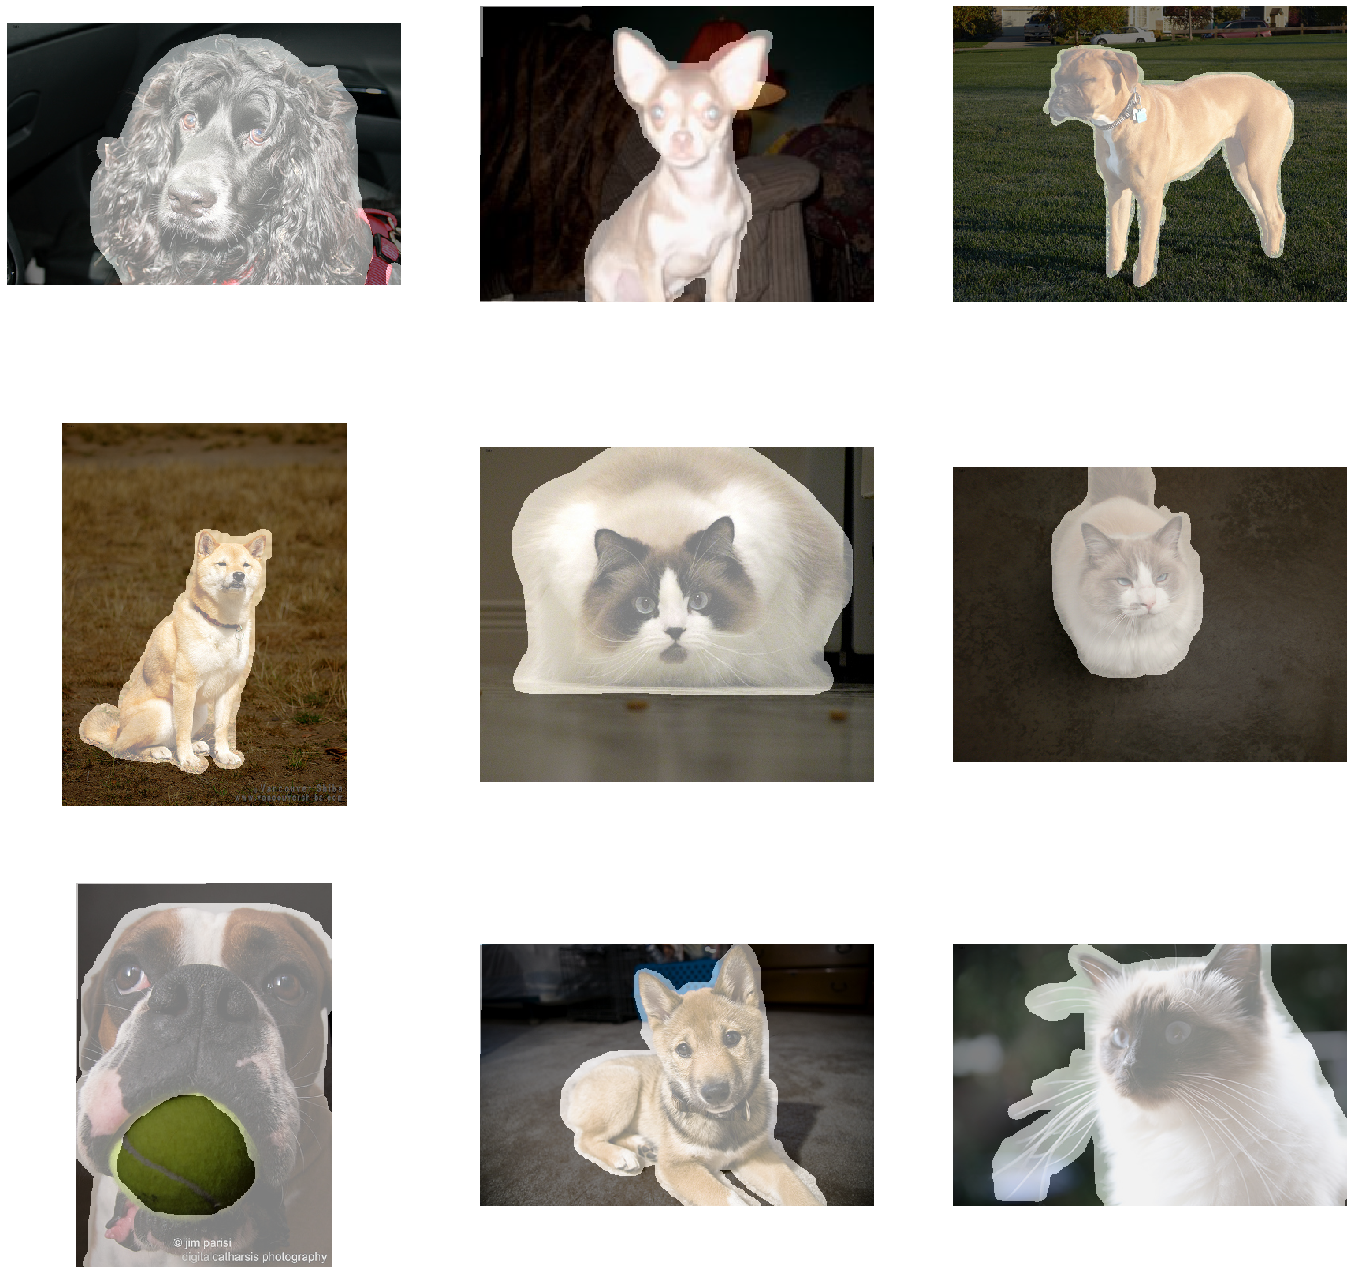

In [7]:
visualization_filenames = random_generator.choice(
    train_images_filenames, size=9, replace=False,
)
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
for ax, image_filename in zip(axes.flatten(), visualization_filenames):
    image = cv2.imread(os.path.join(images_directory, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(
        os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), 
        cv2.IMREAD_UNCHANGED,
    )
    mask = preprocess_mask(mask)
    
    ax.imshow(image, interpolation="none")
    ax.imshow(mask, cmap="gray", alpha=0.5, interpolation="none")
    ax.set_axis_off()

plt.show()

### Image sizes for training and prediction

As you can see, images have different heights, widths and aspect ratios. That fact brings two challenges to a deep learning pipeline:

* PyTorch requires all images in a batch to have the same height and width.
* If a neural network is not fully convolutional, you have to use the same width and height for all images during training and inference.
* Generally, fully convolutional architectures can work with images of any size. However, some architectures, such as U-Net, require that an image's size must be divisible by a downsampling factor of a network (usually 32).

There are three common ways to deal with those challenges:

1. Resize all images and masks to a fixed size during training. After a model predicts a mask with that fixed size during inference, resize the mask to the original image size. This approach is simple, but it has a few drawbacks:
    * The predicted mask is smaller than the image, and the mask may lose some context and important details of the original image.
    * This approach may be problematic if images in your dataset have different aspect ratios. For example, suppose you are resizing an image with the size 1024x512 pixels (so an image with an aspect ratio of 2:1) to 256x256 pixels (1:1 aspect ratio). In that case, this transformation will distort the image and may also affect the quality of predictions.
1. If you use a fully convolutional neural network, you can train a model with image crops, but use original images for inference. This option usually provides the best tradeoff between quality, speed of training, and hardware requirements.
1. Do not alter the sizes of images and use source images both for training and inference. With this approach, you won't lose any information. However, original images could be quite large, so they may require a lot of GPU memory. Also, this approach requires more training time to obtain good results.

In this notebook we will use something in between the first two approaches. We will train our model on random resized crops of size 320x320 pixels and inference it on resized images. This is just a duct tape approach for faster validation, you are free to change `A.RandomResizedCrop` to a `A.RandomCrop` and validate on original images to improve the quality of your model.

### Define dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to [data loading tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and a mask and return their augmented versions.

> Please note, that we will use Albumentations for transforms as opposed to the default [torchvision transforms](https://pytorch.org/vision/stable/transforms.html) package. We do that, because Albumentations provide a convenient way to transform targets (such as segmentation masks or keypoints) alongside the input image. Albumentations also provide you with more augmentation options for your CV task.

In [8]:
class OxfordPetDataset(Dataset):
    def __init__(
        self, images_filenames, images_directory, masks_directory, transform=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, index):
        image_filename = self.images_filenames[index]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")),
            cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image, mask

Next, we create augmentation pipelines for the training and validation datasets.

In [9]:
train_transform = A.Compose(
    [
        A.RandomResizedCrop(320, 320),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(
    train_images_filenames, images_directory, masks_directory, transform=train_transform
)

val_transform = A.Compose(
    [
        A.Resize(320, 320), 
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        ToTensorV2(),
    ]
)
val_dataset = OxfordPetDataset(
    val_images_filenames, images_directory, masks_directory, transform=val_transform,
)

## Our network

### U-Net

Historically, people used lots of different approaches to semantic segmentation task (even [before the deep learning](https://edward-rees.com/2019/12/12/segmentation.html)). However, these days it seems that most of them have died out and all thats left is just one approach called U-Net. Originally, U-Net was a specific network, proposed by German scientists headed by Olaf Ronneberger in a [2015 paper](https://arxiv.org/abs/1505.04597), which solved semantic segmentation tasks in biological imaging and won 2015 ISBI cell tracking challenge. Their architecture consisted of encoder and decoder which communicated not only on the last layer of encoder and first layer of decoder (via forwarding the hidden state) but also on higher levels via skip-connections. Here is the picture of their network's architecture:

![U-Net acrhitecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

The exact architecture is not very important, as it did not age well (remember, the original paper was released back in 2015). But the principle of skip-connections from encoder to decoder is very powerful and has been actively used ever since.

Let's implement our own U-Net. We will take original architecture as a reference and use some tweaks from modern CNN architectures. Two of such tweaks are [batch normalization](https://arxiv.org/abs/1502.03167) and [clever weights initialization](https://arxiv.org/abs/1502.01852). In fact, let's define helper module to use them after every convolution.

In [10]:
class ConvBlock(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=1, 
        padding=1, 
        output_padding=1,
        transpose=False,
    ):
        super().__init__()
        
        # We will use this module in both encoder and decoder.
        # For this reason it needs to support both normal and transposed convolutions.
        if transpose:
            self.conv = nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, 
                padding, output_padding, bias=False,
            )
        else:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            )
            
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)
        
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.norm.weight, 1)
        nn.init.constant_(self.norm.bias, 0)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return self.act(x)

Now that we got that out of the way, let's implement our U-Net. As I mentioned earlier, U-Net consists of encoder and decoder. Let's implement `UNetEncoder` and `UNetDecoder` classes before we merge them into `UNet`.

We will start with encoder part. In its own turn, U-Net's encoder also consists of multiple blocks, each of which includes max pooling and two convolutions. To make our implementation lighter, we will use just two convolutions, one of which will have a stride of 2. Let's implement that.

In [11]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # YOUR CODE HERE
        self.block = nn.Sequential(
            ConvBlock(in_channels, out_channels, stride=2),
            ConvBlock(out_channels, out_channels),
        )
    
    def forward(self, x):
        # YOUR CODE HERE
        return self.block(x)

Now that we have our encoder block implemented, we are ready to define encoder itself. Our encoder's `__init__` will take just one parameter: `hidden_channels`. This is a list of numbers of channels. First number represents the amount of channels in input tensor `x` and for each number in list we want to obtain output tensor with specified amount of channels.

In [12]:
class UNetEncoder(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.blocks = nn.ModuleList(
            UNetEncoderBlock(in_channels, out_channels)
            for in_channels, out_channels in zip(
                hidden_channels[:-1], hidden_channels[1:],
            )
        )
    
    def forward(self, x):
        # Each block subsamples input tensor.
        # Skip connection with the biggest size is just input x.
        outputs = [x]
        
        for block in self.blocks:
            # YOUR CODE HERE
            x = block(x)
            outputs.append(x)
        
        return outputs

Now we have finished with encoder and ready to implement the decoder. Just like with encoder, decoder also consists of blocks. In original paper, each block consisted of bilinear upsampling followed by convolution, concatenation with skip connection and 2 additional convolutions. In our implementation we will merge upsampling and first convolution into one transposed convolution.

In [13]:
class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Decoder block upsamples the input tensor then concatenates it with
        # skip connection and runs another convolution.
        # YOUR CODE HERE
        self.upsample = ConvBlock(
            in_channels, out_channels, stride=2, transpose=True,
        )
        self.convs = nn.Sequential(
            ConvBlock(2 * out_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )
        
    def forward(self, x, skip_connection):
        # YOUR CODE HERE
        x = self.upsample(x)
        x = torch.cat([x, skip_connection], dim=1)
        return self.convs(x)

After we implemented decoder block, we are ready to implement decoder itself. To keep consistency with encoder, our decoder will have the same parameter as encoder: `hidden_channels`, which basically represent the same thing and are obtained from encoder's `hidden_channels` via reversing.

In [14]:
class UNetDecoder(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.blocks = nn.ModuleList(
            UNetDecoderBlock(in_channels, out_channels)
            for in_channels, out_channels in zip(
                hidden_channels[:-1], hidden_channels[1:],
            )
        )
        
    def forward(self, encoder_outputs):
        x, *skip_connections = reversed(encoder_outputs)
        for block, skip_connection in zip(self.blocks, skip_connections):
            x = block(x, skip_connection)
        
        return x

Now that we have both encoder and decoder, we are finally ready to implement our U-Net. It will take image with `in_channels` channels (3 channels for RGB in our case) and output tensor with just one channel, which will contain logits for sigmoid. The output of sigmoid will give the probabilities of the `pet` class for every pixel of the image.

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=None):
        super().__init__()
        if hidden_channels is None:
            hidden_channels = [64, 128, 256, 512]
        
        # Our model will receive images with in_channels channels, but
        # encoder expects input with hidden_channels channels.
        # To fix this, we take the original architecture's approach and
        # run our input through 2 consequent convolutions.
        out_channels = hidden_channels[0]
        self.input_convs = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )
        
        # Now its time for our encoder and decoder.
        self.encoder = UNetEncoder(hidden_channels)
        self.decoder = UNetDecoder(hidden_channels[::-1])
        
        # We will predict logits for sigmoid, i.e. 1 number per pixel.
        in_channels = hidden_channels[0]
        self.to_mask = nn.Conv2d(in_channels, out_channels=1, kernel_size=1)
    
    def forward(self, x):
        x = self.input_convs(x)
        encoder_outputs = self.encoder(x)
        x = self.decoder(encoder_outputs)
        return self.to_mask(x).squeeze(1)

The last thing to do before training is to define some metric that we can keep track of during training. For these task I chose the IoU metric. In this case we can compute intersection as the number of pixels with class `pet` in both prediction and target masks and union as the number of pixels with class `pet` in at least one of tensors. To correctly average our metric over batches, I implemented the following helper class.

In [16]:
class IoU:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.reset()
        
    def update(self, prediction, target):
        prediction = (prediction >= self.threshold).long()
        prediction_pet = (prediction == 1)
        target_pet = (target == 1)
        self.intersection += torch.sum(prediction_pet & target_pet)
        self.union += torch.sum(prediction_pet | target_pet)

    def compute(self):
        return self.intersection / self.union
    
    def reset(self):
        self.intersection = 0
        self.union = 0

### Training U-Net

Now that we have everything in order, let's go ahead and train our model. We will use `AdamW` optimizer with `OneCycleLR` scheduler and will keep track of our losses and metric values with wandb logging. Here is how our training loop looks like.

In [17]:
def train(model, n_epochs, batch_size, learning_rate):
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
    
    criterion = nn.BCEWithLogitsLoss()
    iou = IoU()
    
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, learning_rate, epochs=n_epochs, 
        steps_per_epoch=len(train_dataloader),
    )
    
    for epoch in trange(n_epochs, desc="epochs"):
        model.train()
        for images, target in tqdm(train_dataloader, desc="training", leave=False):
            images, target = images.to(device), target.to(device)
            prediction = model(images)
            loss = criterion(prediction, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            wandb.log({"train_loss": loss})
        
        with torch.no_grad():
            model.eval()
            iou.reset()
            val_loss = 0
            for images, target in tqdm(val_dataloader, desc="validation", leave=False):
                images, target = images.to(device), target.to(device)
                prediction = model(images)
                val_loss += criterion(prediction, target)
                iou.update(prediction, target)
            
        val_loss /= len(val_dataloader)
        wandb.log({
            "epoch": epoch,
            "val_loss": val_loss,
            "iou": iou.compute(),
        })

Now we are ready to actually train our model.

In [ ]:
# Create our model.
model = UNet().to(device)

# With wandb training is done in so-called runs.
# Each run is a separate training of a model.
# We can start a run using wandb.init(...) function.
wandb.init(entity="binpord", project="ml-mipt-segmentation-seminar")

# Train our model.
train(model, n_epochs=10, batch_size=8, learning_rate=3e-4)

In [19]:
# Finish wandb run.
wandb.finish()

Let's visualize our predictions.

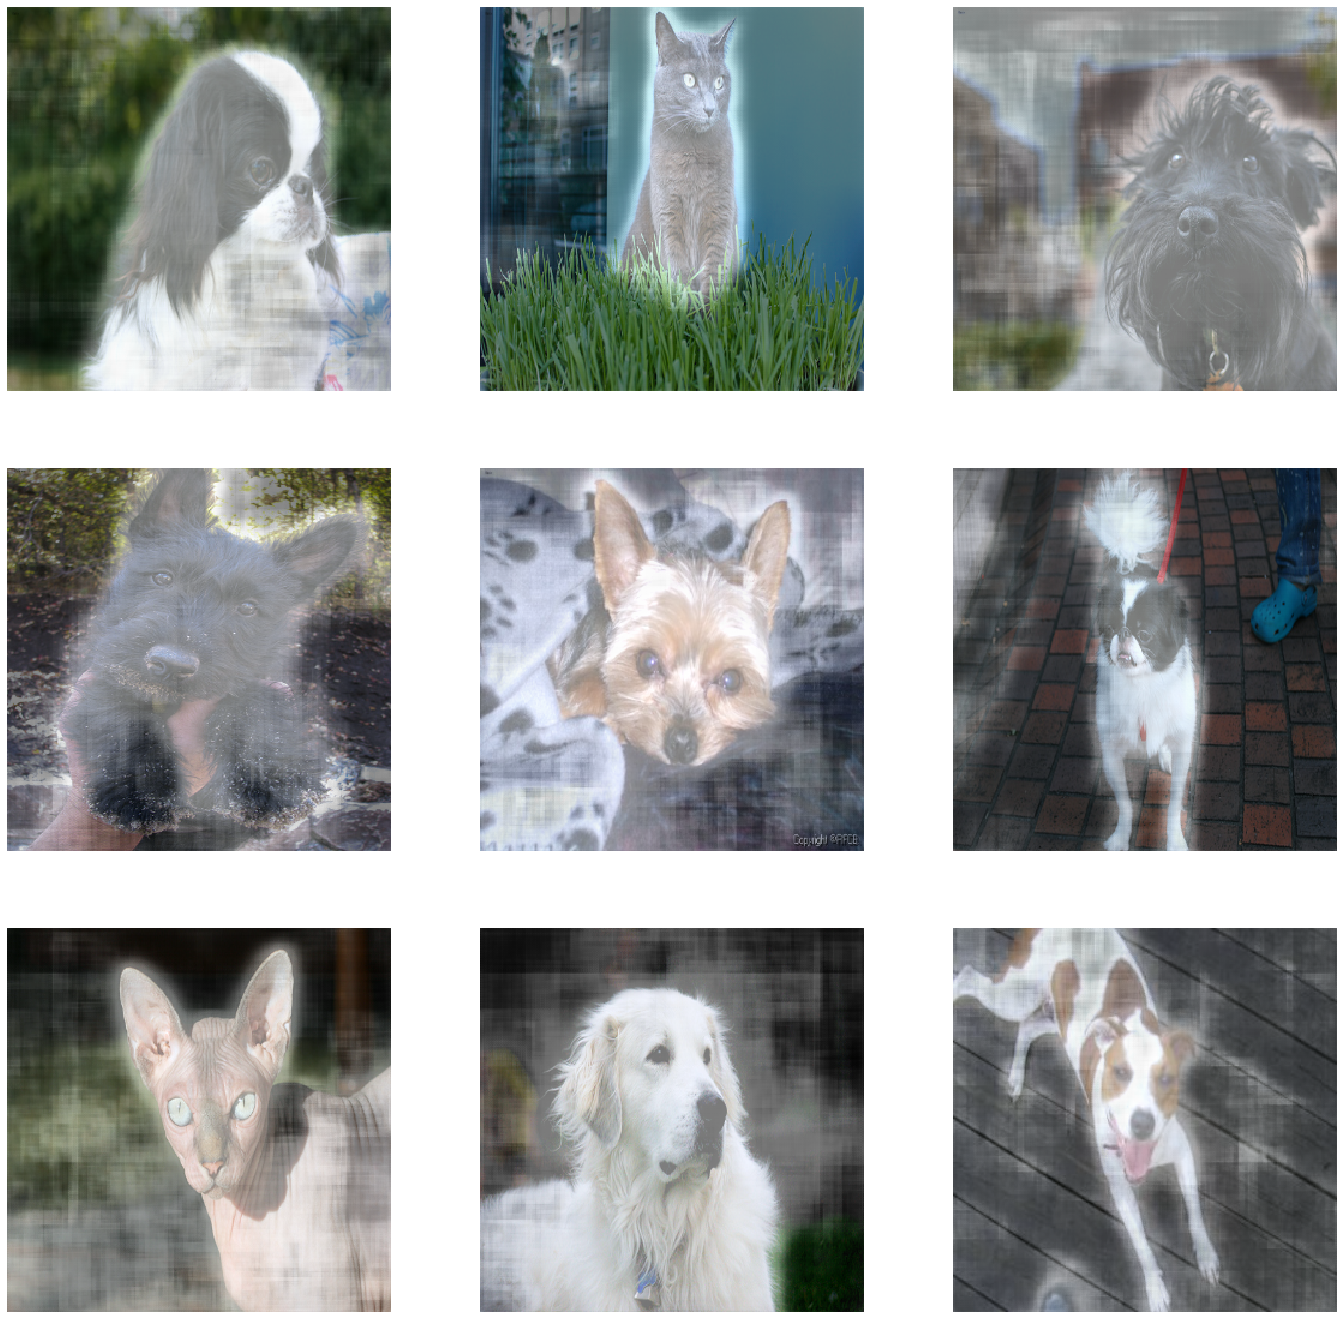

In [20]:
# Our images are normalized (see val_transform).
# In order to visualize them, we need to undo normalization.
# This can be done using another normalize with specific parameters.
# https://github.com/pytorch/vision/issues/528
mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])
denormalize = A.Normalize(
    (-mean / std).tolist(), (1.0 / std).tolist(), max_pixel_value=1.0,
)

visualization_indices = random_generator.choice(
    len(val_dataset), size=9, replace=False,
)
images = torch.cat(
    [val_dataset[i][0][None, ...] for i in visualization_indices], dim=0,
)
model.eval()
with torch.no_grad():
    prediction = model(images.to(device)).cpu()
    prediction = torch.sigmoid(prediction)
    
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
for i, ax in enumerate(axes.flatten()):
    image, predicted_mask = images[i], prediction[i]
    image = denormalize(image=image.permute(1, 2, 0).numpy())["image"].clip(0, 1)
    ax.imshow(image, interpolation="none")
    ax.imshow(predicted_mask, cmap="gray", alpha=0.5, interpolation="none")
    ax.set_axis_off()

plt.show()

### U-Net with pretrained backbone

We trained our model and got a decent IoU of almost 78%. Thats great! Can we do better? Sure we can! We used multiple modern tricks to improve our model, but we did not use the most important trick of all - transfer learning. Transfer learning allows us to train more powerful models using less data and less epochs and achieve better results. Let's use that. The default way to obtain pretrained models in PyTorch is the [torchvision](https://pytorch.org/vision/stable/models.html) package. However, torchvision is not updated very frequently and does nothing to simplify U-Net creation. On the other hand, the `timm` package provides a far wider choice of models and many of them can be loaded with `features_only=True` to output intermediate feature maps from model just like we did in our encoder. For this reason we will use `timm`.

Let's define our model.

In [21]:
class PretrainedUNet(nn.Module):
    def __init__(self, backbone, backbone_channels):
        super().__init__()
        self.backbone = backbone
        self.decoder = UNetDecoder(backbone_channels[::-1])
        
        # For most models, the first output is still half the original size.
        # For this reason I use another up-block, but without skip connection.
        in_channels = backbone_channels[0]
        out_channels = 1
        self.to_mask = nn.Sequential(
            ConvBlock(in_channels, in_channels // 2, stride=2, transpose=True),
            ConvBlock(in_channels // 2, in_channels // 2),
            nn.Conv2d(in_channels // 2, out_channels, kernel_size=1),
        )
        
        # Freeze backbone parameters to train only our decoder.
        for p in self.backbone.parameters():
            p.requires_grad = False
    
    def forward(self, x):
        backbone_outputs = self.backbone(x)
        x = self.decoder(backbone_outputs)
        return self.to_mask(x).squeeze(1)

In [ ]:
# Create our model.
backbone = timm.create_model(
    'efficientnetv2_rw_s', pretrained=True, features_only=True,
)
model = PretrainedUNet(backbone, backbone_channels=[24, 48, 64, 160, 272]).to(device)

# With wandb training is done in so-called runs.
# Each run is a separate training of a model.
# We can start a run using wandb.init(...) function.
wandb.init(entity="binpord", project="ml-mipt-segmentation-seminar")

# Train our model.
train(model, n_epochs=10, batch_size=12, learning_rate=1e-3)

In [23]:
# Finish wandb run.
wandb.finish()

It sure beats our vanila implementation! Transfer learning is, probably, the most important thing in moden machine learning and here we can clearly see why.

Let's visualize our predictions on the same images we used in our previous visualization.

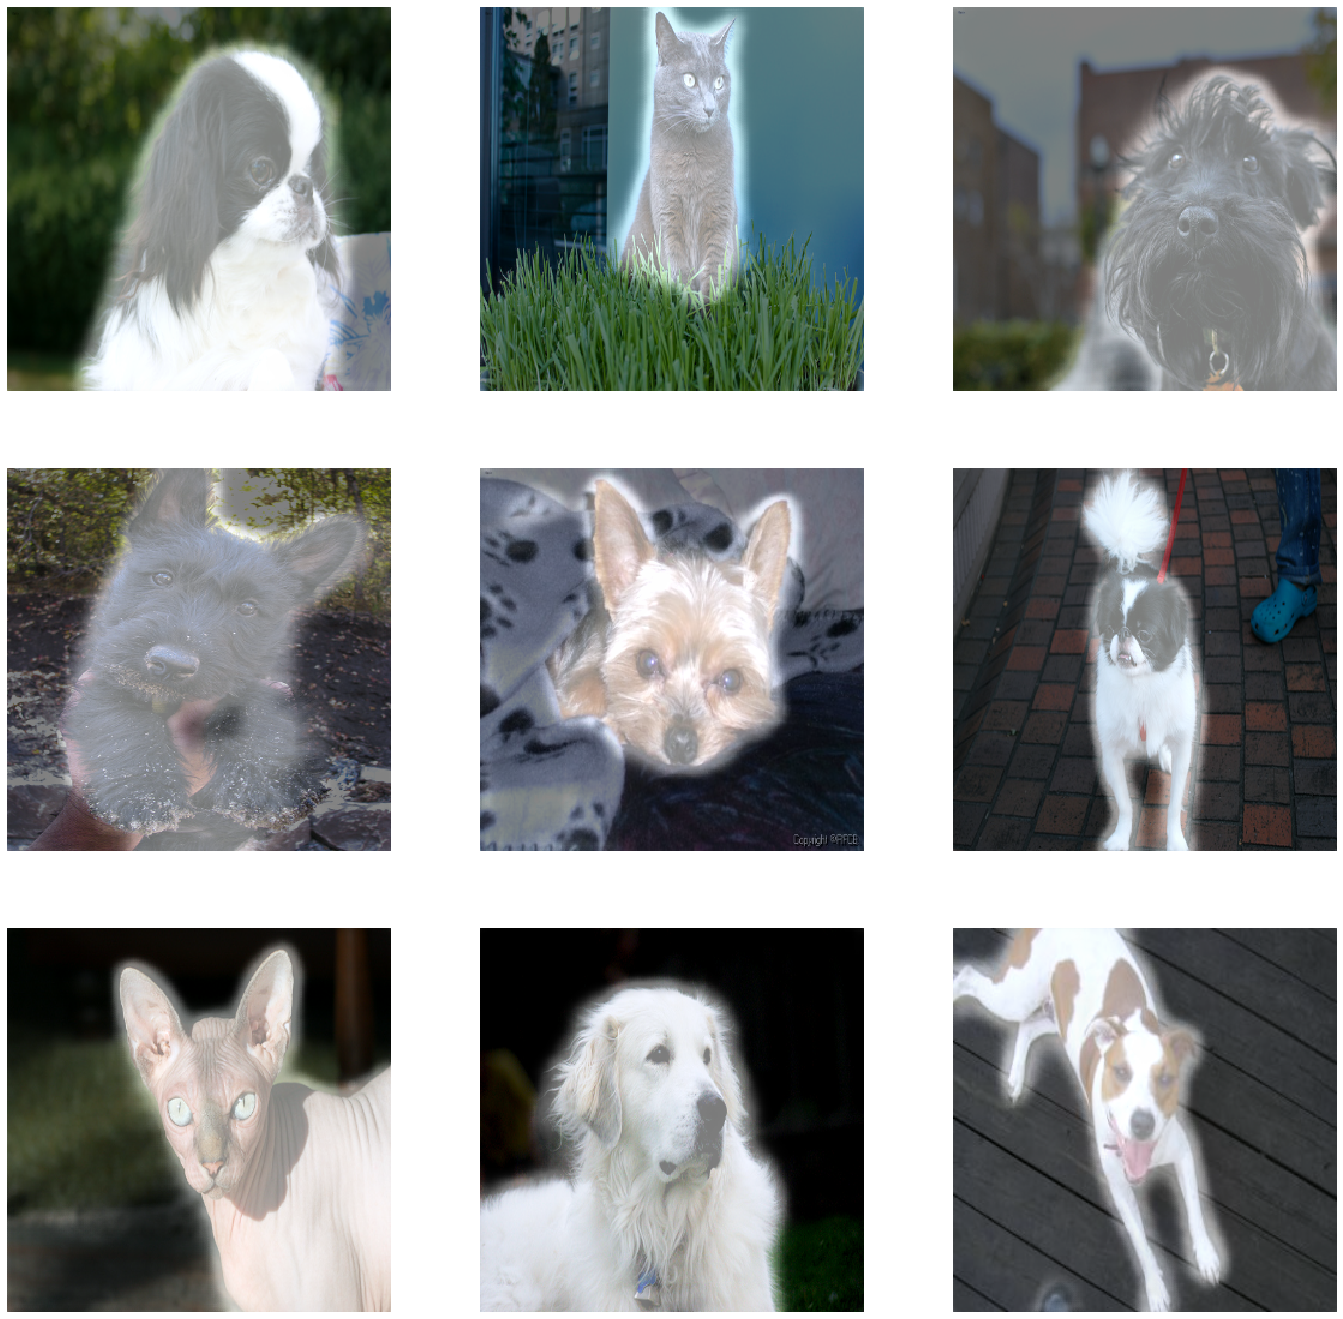

In [24]:
images = torch.cat(
    [val_dataset[i][0][None, ...] for i in visualization_indices], dim=0,
)
model.eval()
with torch.no_grad():
    prediction = model(images.to(device)).cpu()
    prediction = torch.sigmoid(prediction)
    
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
for i, ax in enumerate(axes.flatten()):
    image, predicted_mask = images[i], prediction[i]
    image = denormalize(image=image.permute(1, 2, 0).numpy())["image"].clip(0, 1)
    ax.imshow(image, interpolation="none")
    ax.imshow(predicted_mask, cmap="gray", alpha=0.5, interpolation="none")
    ax.set_axis_off()

plt.show()